In [1]:
# Load key from .env
key = open(".env").readline() 
key = key.strip()


which: no ccache in (/home/sam/Documents/GitHub/KNU_AI_Class/.venv/bin:/home/sam/.pyenv/libexec:/home/sam/.pyenv/plugins/python-build/bin:/home/sam/.pyenv/plugins/pyenv-virtualenv/bin:/home/sam/.pyenv/plugins/pyenv-update/bin:/home/sam/.pyenv/plugins/pyenv-doctor/bin:/home/sam/Documents/GitHub/KNU_AI_Class/.venv/bin:/home/sam/.pyenv/plugins/pyenv-virtualenv/shims:/home/sam/.pyenv/shims:/home/sam/.pyenv/bin:/home/linuxbrew/.linuxbrew/bin:/home/linuxbrew/.linuxbrew/sbin:/home/sam/.pyenv/plugins/pyenv-virtualenv/shims:/home/sam/.pyenv/bin:/home/linuxbrew/.linuxbrew/bin:/home/linuxbrew/.linuxbrew/sbin:/home/sam/.pyenv/plugins/pyenv-virtualenv/shims:/home/sam/.pyenv/bin:/home/linuxbrew/.linuxbrew/bin:/home/linuxbrew/.linuxbrew/sbin:/home/sam/.nvm/versions/node/v22.14.0/bin:/home/sam/.local/bin:/home/sam/bin:/usr/local/bin:/usr/local/sbin:/usr/bin:/usr/sbin)
/home/sam/Documents/GitHub/KNU_AI_Class/.venv/lib64/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWar

[2025/05/21 12:54:26] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/sam/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/sam/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, ma

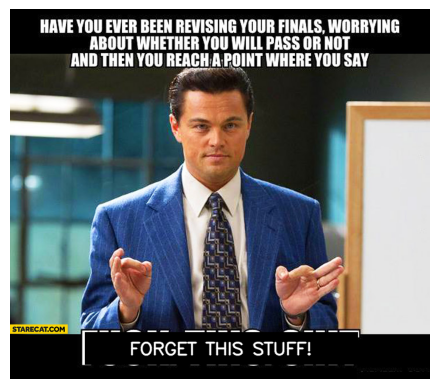

In [ ]:
import cv2
import numpy as np
from paddleocr import PaddleOCR
from openai import OpenAI
import matplotlib.pyplot as plt

# === Setup OpenAI client ===
client = OpenAI(api_key=key)  # ← 🔑 Replace with your actual key

# === Load image ===
img_path = "image_1007.jpg"
image = cv2.imread(img_path)

# === Run OCR ===
ocr = PaddleOCR(use_angle_cls=True, lang='en')
result = ocr.ocr(img_path, cls=True)


def black_box_and_replace(image, box, cleaned_text, font_scale=1.0, thickness=2):
    pts = np.array(box).astype(np.int32)
    x1 = min([p[0] for p in pts])
    y1 = min([p[1] for p in pts])
    x2 = max([p[0] for p in pts])
    y2 = max([p[1] for p in pts])

    # Draw solid black rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 0), thickness=-1)

    # Calculate font size to fit the box
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_size, _ = cv2.getTextSize(cleaned_text, font, font_scale, thickness)
    text_width, text_height = text_size

    # Adjust font size to fit the box
    max_width = x2 - x1 - 10
    while text_width > max_width and font_scale > 0.3:
        font_scale -= 0.05
        text_size, _ = cv2.getTextSize(cleaned_text, font, font_scale, thickness)
        text_width, text_height = text_size

    # Center text in box
    text_x = x1 + (x2 - x1 - text_width) // 2
    text_y = y1 + (y2 - y1 + text_height) // 2

    # Draw white text on black box
    cv2.putText(image, cleaned_text, (text_x, text_y), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

    return image

# === Process Each OCR Text Box ===
for line in result[0]:
    box = line[0]
    text = line[1][0].strip()

    if len(text) < 2:
        continue  # skip short garbage

    prompt = f"""
You are a content moderation assistant for meme captions.

Your job is to check if the input text is inappropriate for children under 13.

If the input **contains inappropriate language**, rewrite it into a **natural, clean, and child-appropriate version** that:
- Preserves the original intent or emotion (e.g., frustration, surprise, humor)
- Uses **real and understandable words**
- Avoids made-up substitutes or censored spellings (e.g., no asterisks or partial words)
- Uses normal sentence structure (not dot-separated words)

Keep the new version **similar in length** to the original so it fits visually in the image.
Also, as the OCR detection can be unstable, I provide you with just one OCR'red line, as well as the complete ocr detectio.
This can enable you to use the complete context of the meme for your decision.

The full OCR context: {result[0]} <-- the full context is just for meaningful meme context, this does not influence your answer in terms of if its SAFE or not.

Just the current line: {text} <-- if the current does not contain any impolite or inappropriate words (also slang), just reply with SAFE.

Only reply either with "SAFE" or the child-friendly version of the text. Do not include your reasoning or any other context in your answer.
"""

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.3,
            max_tokens=60
        )
        reply = response.choices[0].message.content
        if reply != None:
            reply = reply.strip()
    except Exception as e:
        print(f"⚠️ GPT failed on '{text}': {e}")
        continue

    print(f"🧠 Original: {text} → GPT Reply: {reply}")

    # === Filter safe results ===
    if reply != None and reply.upper() != "SAFE":
        cleaned_text = reply.replace('"', '').replace("...", " ").replace("..", " ").replace(".", " ").strip()
        # Check if the original text was in only uppercase
        cleaned_text = cleaned_text.capitalize()
        if text == text.upper():
            cleaned_text = cleaned_text.upper()
        print("Capitalized:", cleaned_text)
        image = black_box_and_replace(image, box, cleaned_text)

# === Save Final Output ===
cv2.imwrite("partially_cleaned_image2.jpg", image)
print("✅ Saved: partially_cleaned_image2.jpg")

# plot the image

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
